### Cost Benefit Questions

1. How would you rephrase the business problem if your model was optimizing toward _precision_? i.e., How might the model behave differently, and what effect would it have?
2. How would you rephrase the business problem if your model was optimizing toward _recall_?
3. What would the most ideal model look like in this case?


### Visualizing models over variables

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../../assets/dataset/flight_delays.csv')
df = df.loc[df.DEP_DEL15.notnull()].copy()

In [2]:
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,DEP_TIME,DEP_DEL15,Unnamed: 15
0,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,900,855,0,NaN
1,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,1247802,31703,900,856,0,NaN
2,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,1230,1226,0,NaN
3,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,1247802,31703,1220,1214,0,NaN
4,1,4,2015-01-01,AA,19805,AA,11298,1129803,30194,12173,1217302,32134,1305,1754,1,NaN


In [3]:
#What is going on here? We convert Carrier which is clearly a categorical variable to dummies. Same with Day of Week

df = df[df.DEP_DEL15.notnull()]
df = df.join(pd.get_dummies(df['CARRIER'], prefix='carrier'))
df = df.join(pd.get_dummies(df['DAY_OF_WEEK'], prefix='dow'))
model = lm.LogisticRegression()

#Only keep the Day of Week in a feature list
features = [i for i in df.columns if 'dow_' in i]

In [4]:
df.shape

(458311, 37)

In [5]:
#Add CRS_DEP_TIME to feature list. CRS_DEP_TIME = Scheduled departure time
features += ['CRS_DEP_TIME']
model.fit(df[features[1:]], df['DEP_DEL15'])    #We start the index of features[1:] at 1 to remove one dummy column.

#The .T operation is to take the Transpose of the 2-dimensional array. Instead of a n*2 array we get a 2*n array.
#We keep only the second row which corresponds to Probability of Delay.
df['probability'] = model.predict_proba(df[features[1:]]).T[1]

In [11]:
print df.head()

   DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE UNIQUE_CARRIER  AIRLINE_ID CARRIER  \
0             1            4  2015-01-01             AA       19805      AA   
1             1            4  2015-01-01             AA       19805      AA   
2             1            4  2015-01-01             AA       19805      AA   
3             1            4  2015-01-01             AA       19805      AA   
4             1            4  2015-01-01             AA       19805      AA   

   ORIGIN_AIRPORT_ID  ORIGIN_AIRPORT_SEQ_ID  ORIGIN_CITY_MARKET_ID  \
0              12478                1247802                  31703   
1              12892                1289203                  32575   
2              12478                1247802                  31703   
3              12892                1289203                  32575   
4              11298                1129803                  30194   

   DEST_AIRPORT_ID     ...       carrier_VX  carrier_WN  dow_1  dow_2  dow_3  \
0            12892     .

In [8]:
features[0]

'dow_1'

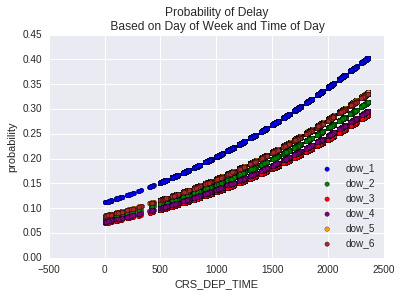

In [14]:
#111 means create a 'grid' of subplots with num_rows = 1, num_columns = 1, and reference the first plot.
ax = plt.subplot(111)

#There are 6 days with a '1' flag possible. Give each a unique color.
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

#Recall that in enumerate, 'e' is the index and 'c' is the item in the list returned as a list of tuples [(0,'blue),(1,'green'),..]
for e, c in enumerate(colors):
    df[df[features[e]] == 1].plot(x='CRS_DEP_TIME', y='probability', kind='scatter', color = c, ax=ax,label = 'dow_'+str((e+1)))

ax.set(title='Probability of Delay\n Based on Day of Week and Time of Day')
ax.legend(loc = 4)


### Other Answers: visualizing Airline or the inverse

In [5]:
features = [i for i in df.columns if 'carrier_' in i]
features += ['CRS_DEP_TIME']
#...

#### Question: What is the worst airline in terms of projected probability of delay? (Note for Nat: Hope it's not F9!)

### Visualizing Performance Against Baseline

#### Visualizing AUC and comparing Models

In [4]:
from sklearn import dummy, metrics

A dummy classifer has a default argument of 'startified' prediction scheme.
It looks at your prior class probabilities (fraction of 1's out of total and fraction of 0's out of total) and will
predict that each new data point has probability of being 1 equal to that fraction of prior 1's.

In [ ]:
model0 = dummy.DummyClassifier('most_frequent')
model0.fit(df[features[1:]], df['DEP_DEL15'])
df['probability_0'] = model0.predict_proba(df[features[1:]]).T[1]

model1 = lm.LogisticRegression()
model.fit(df[features[1:]], df['DEP_DEL15'])
df['probability_1'] = model.predict_proba(df[features[1:]]).T[1]


In [ ]:
df['probability_0'].head()

In [ ]:
df.shape

 (0, 1),
 (0, 1),

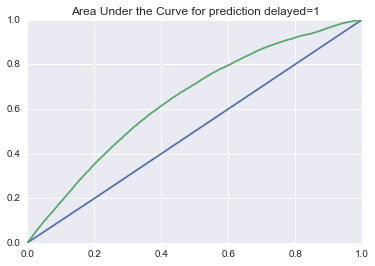

In [21]:
ax = plt.subplot(111)
vals = metrics.roc_curve(df.DEP_DEL15, df.probability_0)
ax.plot(vals[0], vals[1])
vals = metrics.roc_curve(df.DEP_DEL15, df.probability_1)
ax.plot(vals[0], vals[1])

ax.set(title='Area Under the Curve for prediction delayed=1', ylabel='', xlabel='', xlim=(0, 1), ylim=(0, 1))

#### Visualizing Precision / Recall